In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)

# Define the function F and its gradient gF
def F(xi, w, h):
    """Objective function for the short column design problem"""
    return 4 * xi[1] / (w * h**2 * np.exp(xi[2])) + xi[0]**2 / (w**2 * h**2 * np.exp(2 * xi[2]))

def gF(xi, w, h):
    """Gradient of the objective function F"""
    grad = np.zeros(3)
    grad[0] = 2 * xi[0] / (w**2 * h**2 * np.exp(2 * xi[2]))
    grad[1] = 4 / (w * h**2 * np.exp(xi[2]))
    grad[2] = -4 * xi[1] / (w * h**2 * np.exp(xi[2])) - 2 * xi[0]**2 / (w**2 * h**2 * np.exp(2 * xi[2]))
    return grad

# Define the Hessian of F
def HF(xi, w, h):
    """Hessian (second derivative matrix) of the objective function F"""
    H = np.zeros((3, 3))
    temp1 = 1 / (w * h**2 * np.exp(xi[2]))
    temp2 = 1 / (w**2 * h**2 * np.exp(2 * xi[2]))
    
    H[0, 0] = 2 * temp2
    H[0, 2] = H[2, 0] = -4 * xi[0] * temp2
    H[1, 2] = H[2, 1] = -4 * temp1
    H[2, 2] = 4 * xi[1] * temp1 + 4 * xi[0]**2 * temp2
    return H

# Initial parameters
z = 1
n = 3
mu = np.array([500, 2000, 1.604])
Cov = np.array([[10000, 20000, 0],
                [20000, 160000, 0],
                [0, 0, 0.00995]])
InvCov = np.linalg.inv(Cov)
sqCov = np.linalg.cholesky(Cov)  # square root of the covariance matrix
InvSq = np.linalg.inv(sqCov)

# Design variable bounds
v = 200
t = 200
lw, uw = 5, 15
lh, uh = 15, 25

# Function to compute the weight
def weight(theta, prior_mean, prior_cov, bias_mean, bias_cov):
    """Compute the importance sampling weight between two distributions."""
    # dpr = multivariate_normal(prior_mean, prior_cov)
    # dbia = multivariate_normal(bias_mean, bias_cov)
    
    term1 = np.linalg.det(prior_cov)**(-1/2)
    term2 = np.linalg.det(bias_cov)**(1/2)
    term3 = np.exp(0.5 * np.dot((theta - bias_mean).T, np.dot(np.linalg.inv(bias_cov), theta - bias_mean)) - 
                   0.5 * np.dot((theta - prior_mean).T, np.dot(np.linalg.inv(prior_cov), theta - prior_mean)))
    
    return term1*term2*term3

# zero out small values
def zero_small(M, tol=1e-9):
    M[np.abs(M) <= tol] = 0
    return M


In [2]:
def mgf_min(ba, l, x, n):
    """
    minimize the MGF under constraints. from LDT

    """
    mgf = lambda y : sum((y * ba[i]**2 * (1 - y * l[i])) / ((1 - 2 * y * l[i])**2) + l[i] / (1 - 2 * y * l[i]) for i in range(n))
    objective = lambda y : (mgf(y) - x)**2
    bounds = [(0, None)]  # y >= 0 constraint
    result = minimize(objective, x0=[0.1], bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        return result.x[0]  # Return the optimal y value
    else:
        raise ValueError("Optimization failed!")

# tunable params
ba = np.array([1.0, 2.0, 3.0])
l = np.array([0.1, 0.2, 0.3])
x = 1.0
n = len(ba)

# Solve
optimal_y = mgf_min(ba, l, x, n)


In [4]:
def adaptive_importance_sampling(mu, Cov, lw, uw, lh, uh, num_samples=1000):
    """
    Perform adaptive importance sampling for the short column design problem.
    
    Parameters:
    - mu: Mean
    - Cov: Covariance 
    - lw, uw: Lower and upper bounds for the variable w.
    - lh, uh: Lower and upper bounds for the variable h.
    - num_samples: Number of samples
    
    Returns:
    - Samples with their weights.
    """
    # Generate initial samples from a multivariate normal distribution
    normal_dist = multivariate_normal(mean=mu, cov=Cov)
    samples = normal_dist.rvs(size=num_samples)
    
    # Bound the samples within the constraints for w and h
    w_samples = np.clip(samples[:, 0], lw, uw)
    h_samples = np.clip(samples[:, 1], lh, uh)
    
    # Calculate the function F for all samples
    F_values = np.array([F(samples[i], w_samples[i], h_samples[i]) for i in range(num_samples)])
    
    # Calculate weights using the weight function (with example bias)
    pr_mean = mu 
    pr_cov = Cov 
    bias_mean = mu + np.array([10, 20, 0.1])  #tunable
    bias_cov = Cov * 1.1  # tunable
    
    weights = np.array([weight(samples[i], pr_mean, pr_cov, bias_mean, bias_cov) for i in range(num_samples)])
    
    return samples, weights, F_values

samples, weights, F_values = adaptive_importance_sampling(mu, Cov, lw, uw, lh, uh)

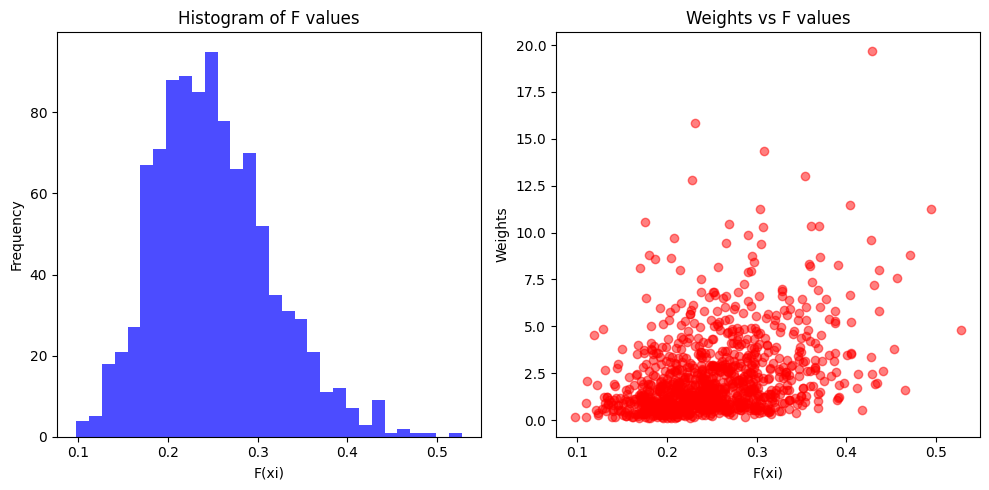

In [5]:
import matplotlib.pyplot as plt

# Visualization of the distribution of function F values and their corresponding weights
def visualize_sampling_results(samples, F_values, weights):
    
    # Plot histogram of F values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(F_values, bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of F values')
    plt.xlabel('F(xi)')
    plt.ylabel('Frequency')
    
    # Scatter plot of weights vs F values
    plt.subplot(1, 2, 2)
    plt.scatter(F_values, weights, color='red', alpha=0.5)
    plt.title('Weights vs F values')
    plt.xlabel('F(xi)')
    plt.ylabel('Weights')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

# Example of visualizing the sampling results
visualize_sampling_results(samples, F_values, weights)
